In [45]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
from prettytable import PrettyTable
import pickle
import warnings
print("Setup Complete")

Setup Complete


### Read mental health dataset from Kaggle as dataframe and analyze it

In [2]:
combined = pd.read_csv("data/combined_data.csv", index_col=0)

In [3]:
combined

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [4]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
# there are almost no missing values
missing_values = combined.isna().sum().div(combined.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_values.columns  = ['% missing_values']
missing_values

,% missing_values
statement,0.682465
status,0.000000


In [87]:
# Copied from https://www.kaggle.com/code/sahityasetu/sentiment-analysis-for-mental-health-monitoring
combined['statement_length'] = combined['statement'].apply(lambda x: len(str(x)))
print(combined['statement_length'].describe())

count    53043.000000
mean       574.784816
std        844.707198
min          2.000000
25%         77.000000
50%        313.000000
75%        748.000000
max      32759.000000
Name: statement_length, dtype: float64


<Axes: xlabel='statement_length', ylabel='Count'>

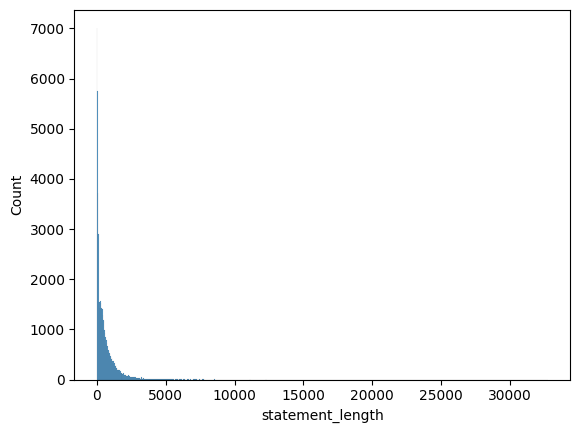

In [88]:
sns.histplot(combined["statement_length"])

In [92]:
combined['statement_no_words'] = combined['statement'].apply(lambda x: len(str(x).split()))
print(combined['statement_no_words'].describe())

count    53043.000000
mean       112.393285
std        163.436684
min          1.000000
25%         15.000000
50%         61.000000
75%        147.500000
max       6300.000000
Name: statement_no_words, dtype: float64


<Axes: xlabel='statement_no_words', ylabel='Count'>

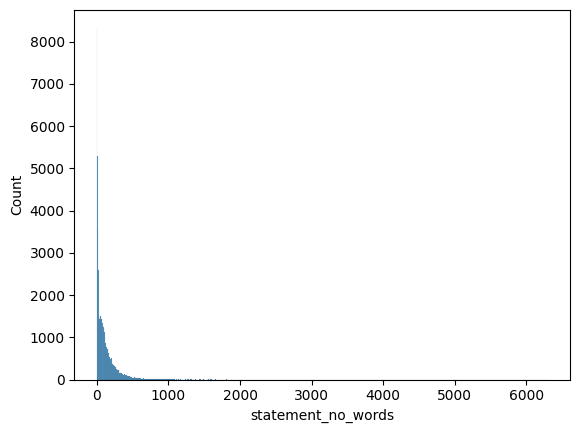

In [93]:
sns.histplot(combined['statement_no_words'])

In [6]:
status_count = combined.groupby("status").count()
status_count

,statement
status,
Anxiety,3841
Bipolar,2777
Depression,15404
Normal,16343
Personality disorder,1077
Stress,2587
Suicidal,10652


In [19]:
transposed_status_count = status_count.T
transposed_status_count

status,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
statement,3841,2777,15404,16343,1077,2587,10652


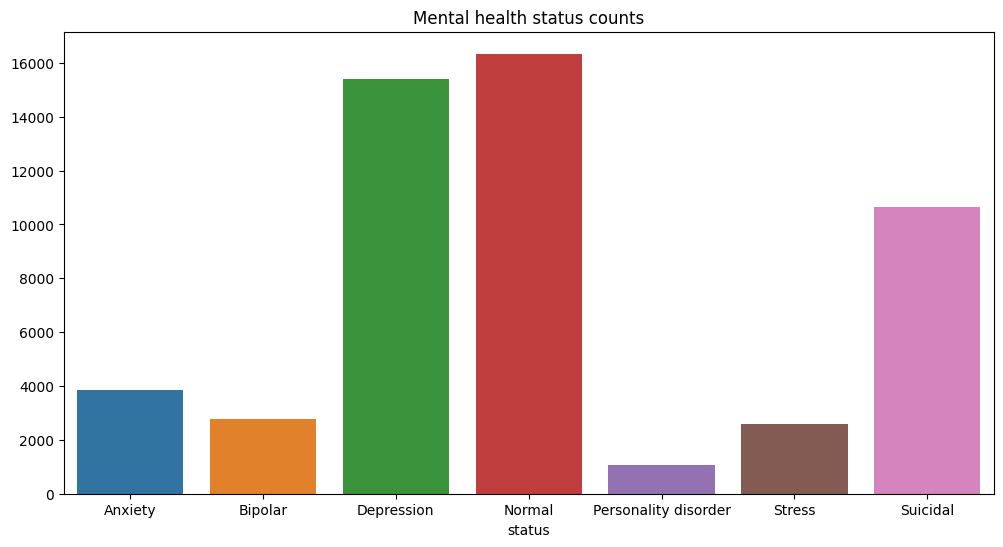

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(data=transposed_status_count).set_title("Mental health status counts")
plt.show()

### Experiment with bag of words matrix based on free text in statements

In [9]:
# see https://stackoverflow.com/questions/70719940/how-to-get-bag-of-words-and-term-frequency-in-text-format-using-sklearn
# https://scikit-learn.org/stable/modules/feature_extraction.html
statements = combined["statement"].fillna("").tolist()
stop_words = get_stop_words("en")
count_vec = CountVectorizer(stop_words=stop_words)
count_vec_fitted = count_vec.fit_transform(statements)
word_counts = count_vec_fitted.toarray()
words = count_vec.get_feature_names_out()
bag_of_words = pd.DataFrame(data=word_counts, columns=words)
bag_of_words.head()

/Users/michaelkrug/venv/ai/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


,00,000,0000,00000,000000,000000000,00000062,000002,00001,0001,...,ˆðÿ,α2,α3,ấy,𝗘𝘅𝗰𝗲𝗹𝗹𝗲𝗻𝗰𝗲,𝗛𝗼𝘀𝗽𝗶𝘁𝗮𝗹,𝗠𝗼𝗿𝗮𝗱𝗮𝗯𝗮𝗱,𝗧𝗿𝘂𝘀𝘁,𝗶𝗻,𝗿𝗲𝗴𝗶𝗼𝗻
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# filter columns by columns sums and regex
bag_of_words = bag_of_words.loc[:, bag_of_words.sum(axis=0) > 100] 
bag_of_words = bag_of_words[list(bag_of_words.filter(regex='[A-Za-z]'))]
bag_of_words.shape

(53043, 2734)

In [11]:
bag_of_words.head()

,20s,2nd,3rd,4th,abandoned,abilify,ability,able,abroad,absolute,...,yesterday,yet,yo,young,younger,youtube,zero,zoloft,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# join bow matrix to original dataset
combined = pd.concat([combined, bag_of_words], axis=1)

In [13]:
# check examples of bow matrix
combined[["status", "statement", "trouble", "mind", "good", "focus"]]

,status,statement,trouble,mind,good,focus
0,Anxiety,oh my gosh,0,0,0,0
1,Anxiety,"trouble sleeping, confused mind, restless hear...",1,1,0,0
2,Anxiety,"All wrong, back off dear, forward doubt. Stay ...",0,0,0,0
3,Anxiety,I've shifted my focus to something else but I'...,0,0,0,1
4,Anxiety,"I'm restless and restless, it's been a month n...",0,0,0,0
...,...,...,...,...,...,...
53038,Anxiety,Nobody takes me seriously I’ve (24M) dealt wit...,0,0,1,0
53039,Anxiety,"selfishness ""I don't feel very good, it's lik...",0,0,1,0
53040,Anxiety,Is there any way to sleep better? I can't slee...,0,0,0,0
53041,Anxiety,"Public speaking tips? Hi, all. I have to give ...",0,0,0,1


In [14]:
grouped = combined.copy()
grouped = grouped.drop("statement", axis=1)
grouped = grouped.groupby("status").sum()
grouped.head()

,20s,2nd,3rd,4th,abandoned,abilify,ability,able,abroad,absolute,...,yesterday,yet,yo,young,younger,youtube,zero,zoloft,zombie,zone
status,,,,,,,,,,,,,,,,,,,,,
Anxiety,13,6,11,15,3,5,22,331,4,23,...,212,182,21,100,36,24,21,73,6,16
Bipolar,16,14,15,8,7,162,47,363,10,26,...,103,175,6,40,22,32,33,59,25,12
Depression,89,46,51,47,87,22,185,1708,54,153,...,332,1063,60,385,240,138,182,167,49,41
Normal,2,17,6,0,4,0,7,146,9,8,...,114,157,19,54,16,36,6,8,2,9
Personality disorder,12,1,7,1,6,1,20,132,9,12,...,19,69,1,28,24,35,18,4,0,14


### Plot top ten words for each mental health status

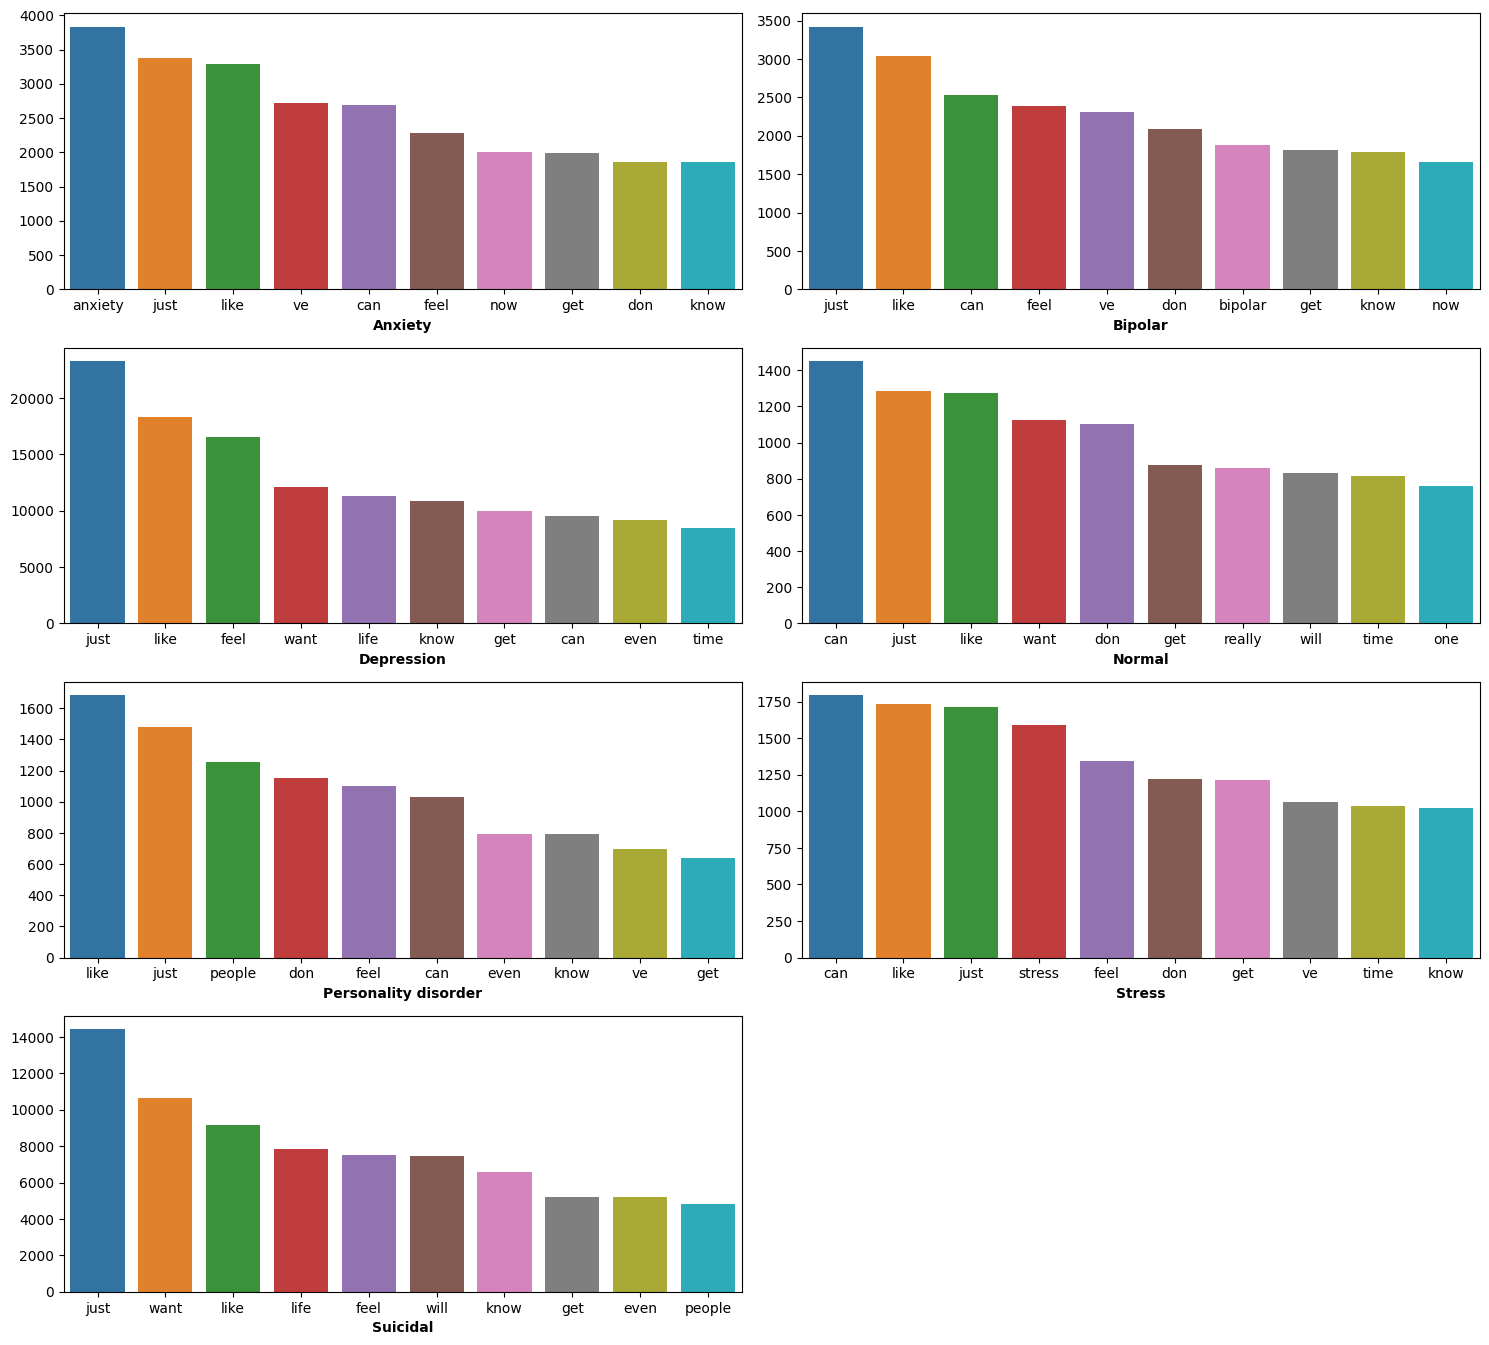

In [16]:
plt.figure(figsize=(15, 100))
for i, index_name in enumerate(grouped.index):
    plt.subplot(30, 2, i+1)
    grouped=grouped.sort_values(by=index_name, ascending=False, axis=1)
    data=grouped.filter(like=index_name, axis=0).iloc[:, : 10]
    sns.barplot(data)
    plt.xlabel(index_name, weight='bold')
    plt.tight_layout()

In [84]:
# Todo: check row divider
table = PrettyTable()
table.add_column("Column", ["Statement", "Status"])
table.add_column("Observation", ["Noisy free text.\nA lot of different words that appear unfrequently.", 
                                 "String format, needs to prepared for modeling."])
table.add_column("Next steps", ["Prepare statements with regex expresssions and colsum filter.\nCreate bag of words matrix.",
                               "Use LabelEncoder to transform status to integers."])
table.align="l"
print(table.get_string())

+-----------+----------------------------------------------------+---------------------------------------------------------------+
| Column    | Observation                                        | Next steps                                                    |
+-----------+----------------------------------------------------+---------------------------------------------------------------+
| Statement | Noisy free text.                                   | Prepare statements with regex expresssions and colsum filter. |
|           | A lot of different words that appear unfrequently. | Create bag of words matrix.                                   |
| Status    | String format, needs to prepared for modeling.     | Use LabelEncoder to transform status to integers.             |
+-----------+----------------------------------------------------+---------------------------------------------------------------+


### Import trained model and respective data columns and analyze feature importances

In [73]:
# load trained xgboost model and train_val_columns
file_name = "xgb_mental_health.pkl"
xgb_model = pickle.load(open("data/"+file_name, "rb"))
train_val_columns = pd.read_csv("data/train_val_columns.csv")

In [80]:
feature_importances = pd.DataFrame()
feature_importances['feature']=train_val_columns.columns
feature_importances['importance'] = xgb_model.feature_importances_
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances[:30].reset_index()[["feature", "importance"]]

,feature,importance
0,symptoms,0.060114
1,stress,0.057117
2,bipolar,0.056383
3,blood,0.042479
4,depression,0.032751
5,stressed,0.030289
6,index,0.020441
7,just,0.018622
8,feel,0.015945
9,anxiety,0.009658


In [113]:
#y_test = pd.read_csv("data/y_test.csv").T
#y_pred = pd.read_csv("data/y_pred.csv").T

import numpy as np
y_test = np.genfromtxt('data/y_test.csv', delimiter=',')
y_pred = np.genfromtxt('data/y_pred.csv', delimiter=',')

In [114]:
y_test

array([nan, nan, nan, ..., nan, nan, nan])

In [115]:
y_pred

array([nan, nan, nan, ..., nan, nan, nan])

In [116]:
from sklearn.metrics import confusion_matrix

# confusion_matrix(y_test.values, y_pred.values)